In [1]:
%matplotlib inline
import pandas as pd
import time
import sys
from pathlib import Path
from pprint import pprint
import numpy as np
from operator import add
from warnings import simplefilter
from tqdm.notebook import tqdm
from datetime import datetime

pd.options.mode.chained_assignment = None #comment if you want the warning message

In [2]:
def arffToDataframe(arff_file, normalize=False):
    from scipy.io import arff
    import pandas as pd
    data = arff.loadarff(arff_file)
    df = pd.DataFrame(data[0])
    df_int = bytesToInt(df)
    if normalize:
        df_int= normalizeDataframe(df_int, normalize)
    return df_int

def bytesToInt(df):
    import pandas as pd
    import numpy as np
    for column in df:
        df[column] = pd.to_numeric(df[column], errors='coerce').fillna(0).astype(np.int64)
    return df

In [3]:
print("Start Time: {}".format(datetime.now()))
begin_time = time.time()

Start Time: 2023-11-26 22:47:05.674572


In [4]:
from operator import add
from sklearn.metrics import roc_curve, auc
import warnings
import os
import sys

#input file name
arff_file = "../mendeley.arff"


#split between training-and-testing dataset
trainsizes_l =[]
for i in np.arange(0.008, 0.8, 0.008):
    train_size = 0
    train_size += i
    trainsizes_l.append(train_size)
trainsizes_l.append(0.8)

#Make test_size a fixed variable
test_size = 0.2

#name of the column defining the label
label_name = 'CLASS_LABEL'

# These are the features used by the classifiers
features = pd.Index(["NumDots",
                        "SubdomainLevel",
                        "PathLevel",
                        "UrlLength",
                        "NumDash",
                        "NumDashInHostname",
                        "AtSymbol",
                        "TildeSymbol",
                        "NumUnderscore",
                        "NumPercent",
                        "NumQueryComponents",
                        "NumAmpersand",
                        "NumHash",
                        "NumNumericChars",
                        "NoHttps",
                        "RandomString",
                        "IpAddress",
                        "DomainInSubdomains",
                        "DomainInPaths",
                        "HttpsInHostname",
                        "HostnameLength",
                        "PathLength",
                        "QueryLength",
                        "DoubleSlashInPath",
                        "NumSensitiveWords",
                        "EmbeddedBrandName",
                        "PctExtHyperlinks",
                        "PctExtResourceUrls",
                        "ExtFavicon",
                        "InsecureForms",
                        "RelativeFormAction",
                        "ExtFormAction",
                        "AbnormalFormAction",
                        "PctNullSelfRedirectHyperlinks",
                        "FrequentDomainNameMismatch",
                        "FakeLinkInStatusBar",
                        "RightClickDisabled",
                        "PopUpWindow",
                        "SubmitInfoToEmail",
                        "IframeOrFrame",
                        "MissingTitle",
                        "ImagesOnlyInForm",
                        "SubdomainLevelRT",
                        "UrlLengthRT",
                        "PctExtResourceUrlsRT",
                        "AbnormalExtFormActionR",
                        "ExtMetaScriptLinkRT",
                        "PctExtNullSelfRedirectHyperlinksRT"
                        ])

malicious_label_value = 1


df = arffToDataframe(arff_file)
#print(df[label_name].value_counts())

#separate benign from malicious

df_mal = df[df[label_name]==malicious_label_value]
df_ben = df[df[label_name]!=malicious_label_value]
print("Total samples: {} Benign samples: {} Phishing samples: {}".format(len(df), len(df_ben), len(df_mal)))
########################################
print('Selecting TRAIN and TEST samples...')

#split up test and train calculation
df_mal['is_test'] = (np.random.uniform(0,1,len(df_mal)) <= test_size)
df_ben['is_test'] = (np.random.uniform(0,1,len(df_ben)) <= test_size)

Total samples: 10000 Benign samples: 5000 Phishing samples: 5000
Selecting TRAIN and TEST samples...


In [5]:
acc_list_sum = []
f1_list_sum = []
precision_list_sum = []
recall_list_sum = []

accuracies_all = []
f1s_all = []
recalls_all = []
precisions_all = []

trials = 30

## We repeat all these evaluations 3
for i in tqdm(range(0,trials)):
    acc_list = []
    f1_list = []
    precision_list = []
    recall_list = []
    for train_size in tqdm(trainsizes_l):
        
        #split up test and train calculation
        df_mal['is_train'] = (np.random.uniform(0,1,len(df_mal)) <= train_size)
        df_ben['is_train'] = (np.random.uniform(0,1,len(df_ben)) <= train_size)

        #print("Creating TRAIN and TEST dataframes...")
        #create own test dataframe
        train = pd.concat([df_mal[df_mal['is_train']==True],df_ben[df_ben['is_train']==True]], ignore_index=True)
        
        #print(len(train))
        #create own test dataframe
        test = pd.concat([df_mal[df_mal['is_test']==True],df_ben[df_ben['is_test']==True]], ignore_index=True)
        #print(test.index)
        #print(len(test))
        #print("Samples: Total={}\tTrain"+str(round(train_size/0.8,2))+"={}\tTest={}".format(len(df),len(train),len(test)))
        #print("Samples: Total={}\tTrain({} % of train sample)={}\tTest={}".format(len(df),round(train_size/0.8,2)*100,len(train),len(test)))

        #print("Legit Samples: Total={}\tTrain={}\tTest={}".format(len(df_ben),len(train[train[label_name]!=malicious_label_value]),len(test[test[label_name]!=malicious_label_value])))

        #print("Phishing Samples: Total={}\tTrain={}\tTest={}".format(len(df_mal),len(train[train[label_name]==malicious_label_value]),len(test[test[label_name]==malicious_label_value])))

        #These are the labels of the training for fitting (and, afterwards, evaluating) the model. 
        train_labels = train[label_name]
        test_labels = test[label_name]
        ###############################################################################################################################################################
        #### Random Forest classifier ####
        # start timer
        start_time = time.time()

        #create random forest classifier
        from sklearn.ensemble import RandomForestClassifier
        rf_clf = RandomForestClassifier(n_estimators=100, criterion='gini', max_depth=None, min_samples_split=2, min_samples_leaf=1, 
                                        min_weight_fraction_leaf=0.0, max_leaf_nodes=None, min_impurity_decrease=0.0, 
                                        bootstrap=True, oob_score=False, n_jobs=-1, random_state=0, 
                                        verbose=0, warm_start=False, class_weight=None)
        rf_name = 'random forest'

        # TRAIN THE CLASSIFIER
        #print("Training {}...".format(type(rf_clf)))
        rf_clf.fit(train[features],train_labels)
        elapsed_time = time.time() - start_time
        #print("...done. Training time: {}".format(elapsed_time))
        ########################################################################
        # TEST CLASSIFIER
        rf_pred = rf_clf.predict(test[features])

        ##################### Metrics ###########################
        from sklearn import metrics    
     
        # Precision, Recall, F1
        PRE, REC, F1, supp = metrics.precision_recall_fscore_support(test_labels, rf_pred, average='binary', pos_label=1, labels=[0, 1])

        #Accuracy
        ACC = metrics.accuracy_score(test_labels, rf_pred)
        acc_list.append(ACC)
        accuracies_all.append(ACC)
        
        #F1-Score
        f1_list.append(F1)
        f1s_all.append(F1)
        
        #Precision
        precision_list.append(PRE)
        precisions_all.append(PRE)
        
        #Recall
        recall_list.append(REC)
        recalls_all.append(REC)
        
    #print(str(acc_list))
    acc_list_sum.append(acc_list)
    f1_list_sum.append(f1_list)
    precision_list_sum.append(precision_list)
    recall_list_sum.append(recall_list)
    #print("FPR: {:.4f}\tTPR: {:.4f}\tF1-score: {:.4f}\tAccuracy: {:.4f}".format(PRE, REC, F1, ACC))



  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

In [6]:
print("End Time: {}".format(datetime.now()))

end_time = time.time()

total_time = end_time - begin_time

print("Runtime: {}s".format(total_time))

End Time: 2023-11-26 22:58:12.661500
Runtime: 666.9869282245636s


In [7]:
#Create Mean_Accuracy_list        
import numpy as np
multiple_lists = acc_list_sum
arrays = [np.array(x) for x in multiple_lists]
result_acc = [np.mean(k) for k in zip( * multiple_lists)]
#print(result_acc)

#Create Mean F1-Score list
multiple_lists_f1 = f1_list_sum
arrays_f1 = [np.array(x) for x in multiple_lists_f1]
result_f1 = [np.mean(k) for k in zip( * multiple_lists_f1)]
#print(result_f1)

#Create Mean Precision list
multiple_lists_precision = precision_list_sum
arrays_precision = [np.array(x) for x in multiple_lists_precision]
result_precision = [np.mean(k) for k in zip( * multiple_lists_precision)]

#Create Mean Recall list
multiple_lists_recall = recall_list_sum
arrays_recall = [np.array(x) for x in multiple_lists_recall]
result_recall = [np.mean(k) for k in zip( * multiple_lists_recall)]

In [8]:
'''Plotting'''
import matplotlib.pyplot as plt
import seaborn as sns

#data preparation
trainsizes_l_new =[]
for i in trainsizes_l:
    trainsizes_l= ((i/80)*100)*100
    trainsizes_l_new.append(trainsizes_l)

In [20]:
acc_one = list()
f1_one = list()
recall_one = list()
precision_one = list()

trial = 2
for i in range(100):
    acc_one.append(accuracies_all[trial*100 + i])
    f1_one.append(f1s_all[trial*100 + i])
    recall_one.append(recalls_all[trial*100 + i])
    precision_one.append(precisions_all[trial*100 + i])

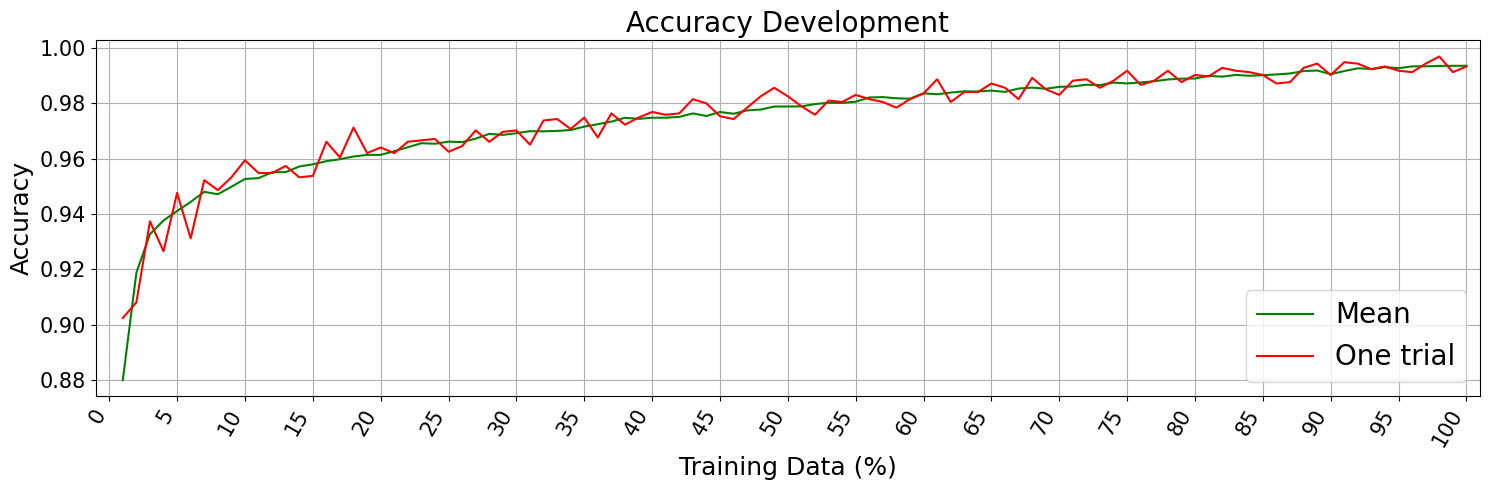

In [21]:
############ Accuracy ##################
plt.figure(figsize=(15, 5))
plt.plot(trainsizes_l_new, result_acc, color ="green", label="Mean")
plt.plot(trainsizes_l_new, acc_one, color ="red", label="One trial")
plt.title("Accuracy Development", fontsize=20)
plt.xlabel("Training Data (%)", fontsize=18)
plt.xticks(np.arange(0, 101, 5),rotation=60, ha='right', fontsize=15)
plt.yticks(fontsize=15)
plt.ylabel("Accuracy", fontsize=18)
plt.legend(loc ="lower right", fontsize=20)
plt.grid()
plt.tight_layout()
plt.xlim([-1,101])

plt.savefig("../figures/exp1/exp1_acc.pdf")
plt.show()

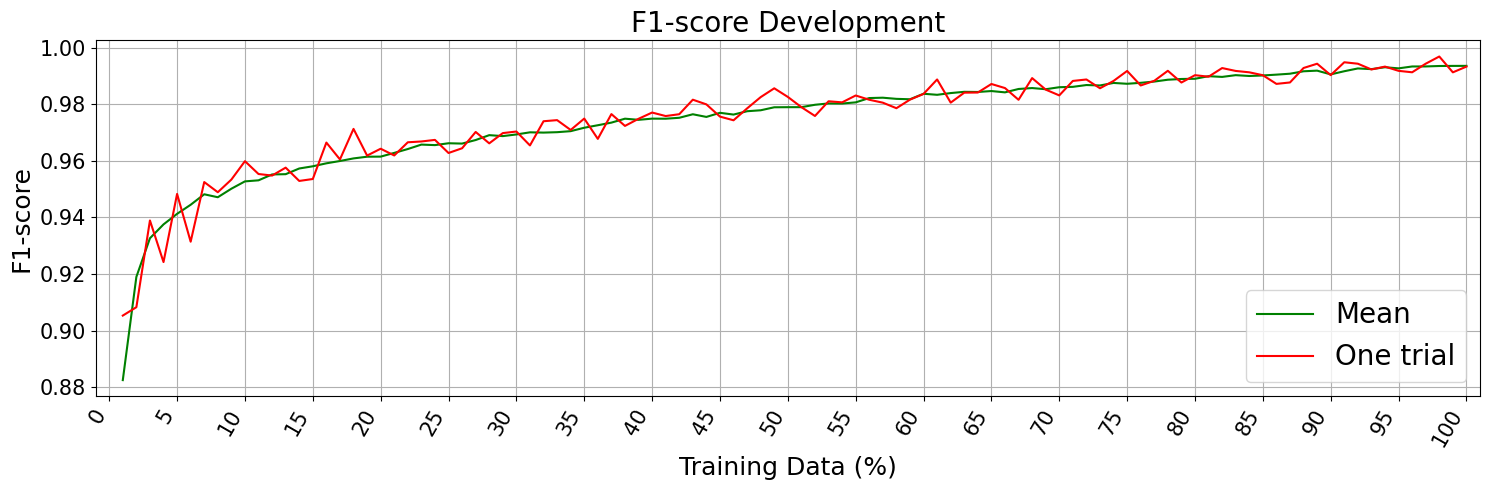

In [22]:
############ F1 ##################
plt.figure(figsize=(15, 5))
plt.plot(trainsizes_l_new, result_f1, color ="green", label="Mean")
plt.plot(trainsizes_l_new, f1_one, color ="red", label="One trial")
plt.title("F1-score Development", fontsize=20)
plt.xlabel("Training Data (%)", fontsize=18)
plt.xticks(np.arange(0, 101, 5),rotation=60, ha='right', fontsize=15)
plt.yticks(fontsize=15)
plt.ylabel("F1-score", fontsize=18)
plt.legend(loc ="lower right", fontsize=20)
plt.grid()
plt.tight_layout()
plt.xlim([-1,101])

plt.savefig("../figures/exp1/exp1_f1.pdf")
plt.show()

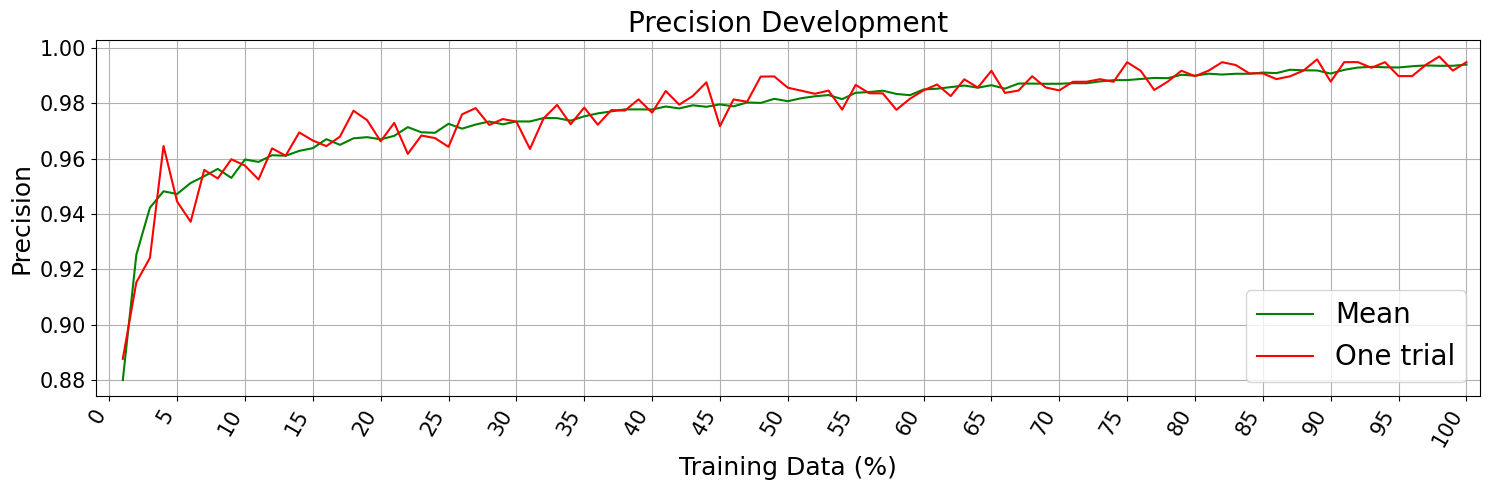

In [23]:
############ PRECISION ##################
plt.figure(figsize=(15, 5))
plt.plot(trainsizes_l_new, result_precision, color ="green", label="Mean")
plt.plot(trainsizes_l_new, precision_one, color ="red", label="One trial")
plt.title("Precision Development", fontsize=20)
plt.xlabel("Training Data (%)", fontsize=18)
plt.xticks(np.arange(0, 101, 5),rotation=60, ha='right', fontsize=15)
plt.yticks(fontsize=15)
plt.ylabel("Precision", fontsize=18)
plt.legend(loc ="lower right", fontsize=20)
plt.grid()
plt.tight_layout()
plt.xlim([-1,101])

plt.savefig("../figures/exp1/exp1_precision.pdf")
plt.show()

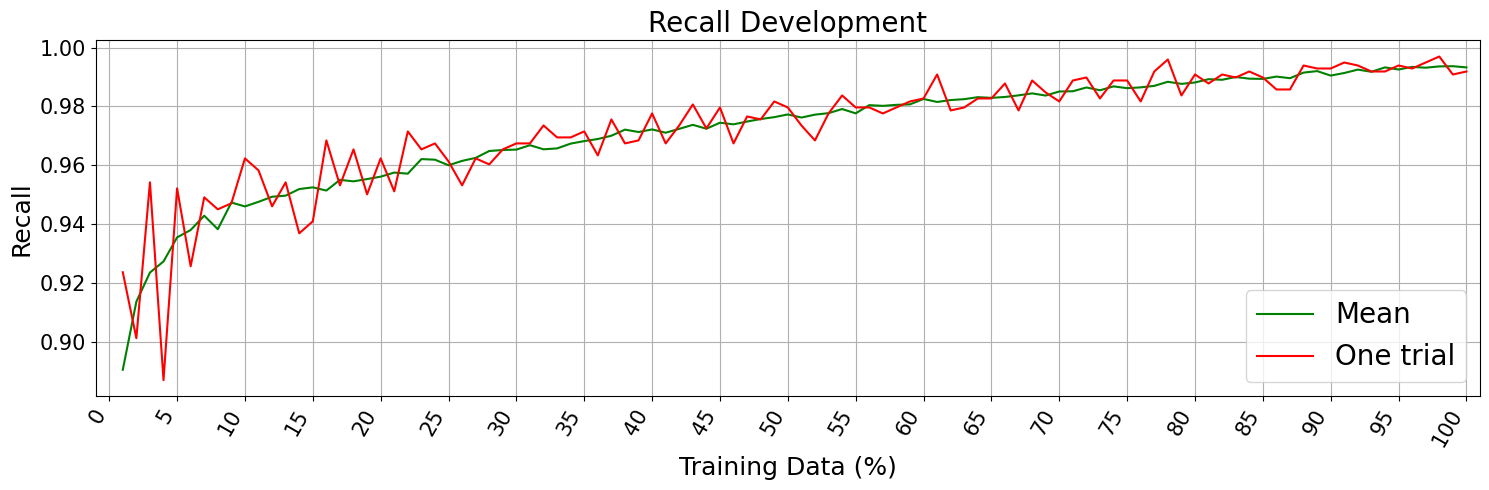

In [24]:
############ RECALL ##################
plt.figure(figsize=(15, 5))
plt.plot(trainsizes_l_new, result_recall, color ="green", label="Mean")
plt.plot(trainsizes_l_new, recall_one, color ="red", label="One trial")
plt.title("Recall Development", fontsize=20)
plt.xlabel("Training Data (%)", fontsize=18)
plt.xticks(np.arange(0, 101, 5),rotation=60, ha='right', fontsize=15)
plt.yticks(fontsize=15)
plt.ylabel("Recall", fontsize=18)
plt.legend(loc ="lower right", fontsize=20)
plt.grid()
plt.tight_layout()
plt.xlim([-1,101])

plt.savefig("../figures/exp1/exp1_recall.pdf")
plt.show()

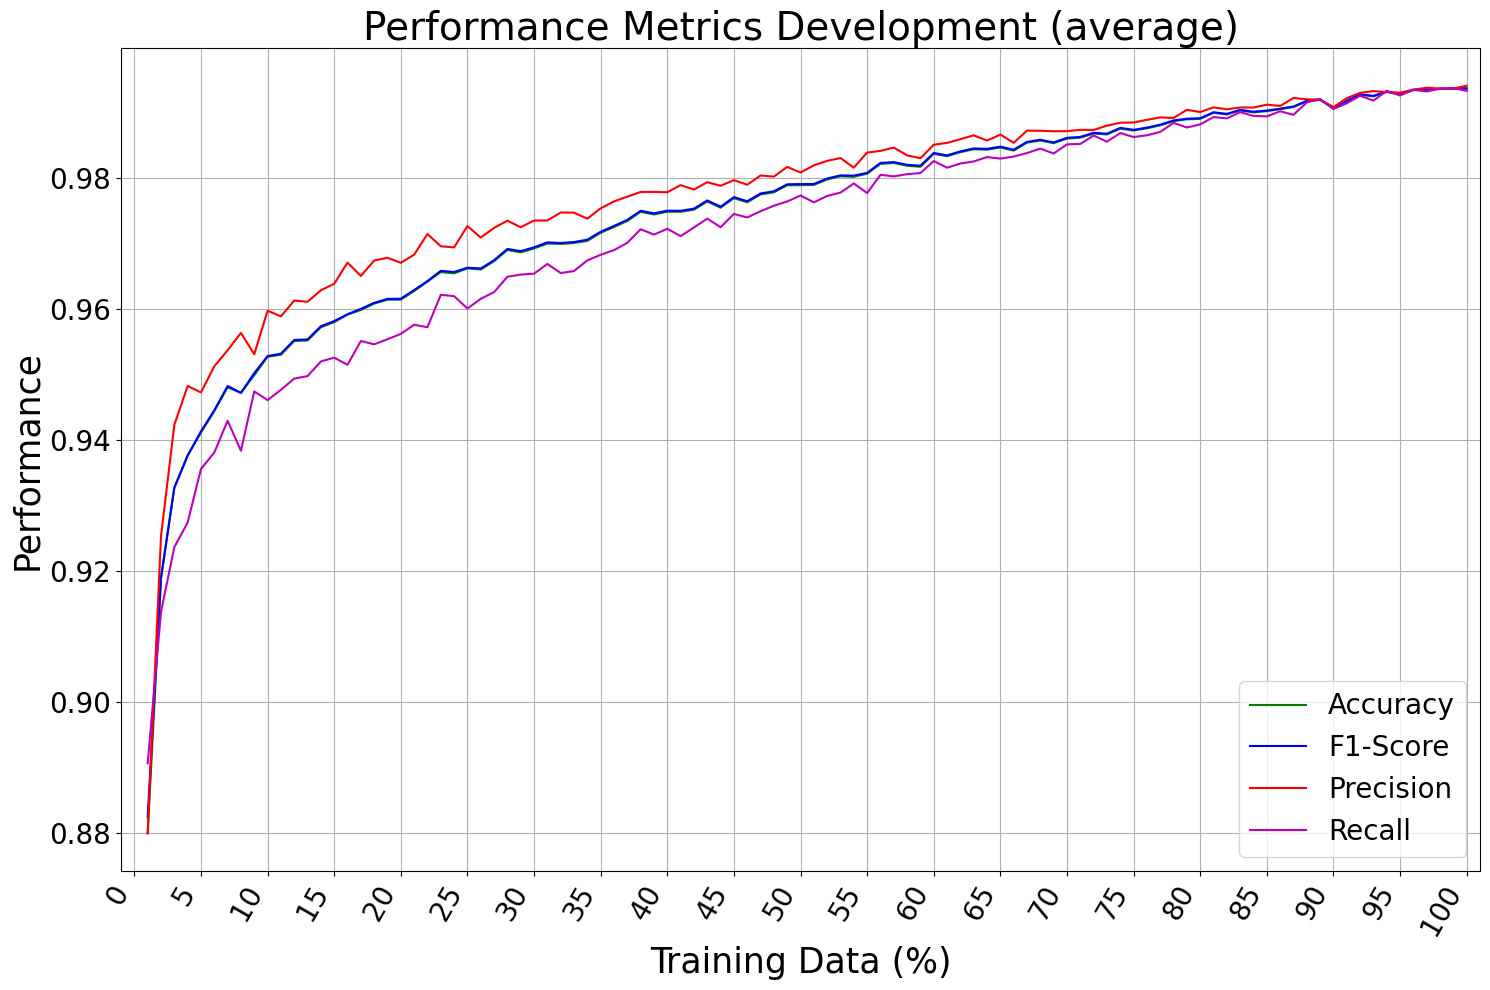

In [14]:
############ ALL ##################

plt.figure(figsize=(15, 10))

plt.plot(trainsizes_l_new, result_acc, 'g-', label = "Accuracy")
plt.plot(trainsizes_l_new, result_f1, 'b-', label = "F1-Score")
plt.plot(trainsizes_l_new, result_precision, 'r-', label = "Precision")
plt.plot(trainsizes_l_new, result_recall, 'm-', label = "Recall")

plt.title("Performance Metrics Development (average)", fontsize=28)
plt.xlabel("Training Data (%)", fontsize=25)
plt.ylabel("Performance", fontsize=25)
plt.xticks(np.arange(0, 101, 5),rotation=60, ha='right', fontsize=20)
plt.yticks(fontsize=20)
plt.legend(loc ="lower right", fontsize=20)

plt.grid()
plt.tight_layout()
plt.xlim([-1,101])

plt.savefig("../figures/exp1/exp1_all.pdf")
plt.show()


In [15]:
#### SAVING RESULTS

import pickle
results_folder = "../results/exp1/"

## Averaged
with open(results_folder + 'acc_avg.pkl', 'wb') as f:
    pickle.dump(result_acc, f)
    
with open(results_folder + 'f1_avg.pkl', 'wb') as f:
    pickle.dump(result_f1, f)

with open(results_folder + 'precision_avg.pkl', 'wb') as f:
    pickle.dump(result_precision, f)

with open(results_folder + 'recall_avg.pkl', 'wb') as f:
    pickle.dump(result_recall, f)
    
## All

with open(results_folder + 'accuracies_all.pkl', 'wb') as f:
    pickle.dump(accuracies_all, f)
    
with open(results_folder + 'f1s_all.pkl', 'wb') as f:
    pickle.dump(f1s_all, f)

with open(results_folder + 'precisions_all.pkl', 'wb') as f:
    pickle.dump(precisions_all, f)

with open(results_folder + 'recalls_all.pkl', 'wb') as f:
    pickle.dump(recalls_all, f)

## Support (just for complete reproducibility)
with open(results_folder + 'mal.pkl', 'wb') as f:
    pickle.dump(df_mal, f)
    
with open(results_folder + 'ben.pkl', 'wb') as f:
    pickle.dump(df_ben, f)

with open(results_folder + 'trainsizes.pkl', 'wb') as f:
    pickle.dump(trainsizes_l_new, f)